# Introduction to Pipelines in Python

## Objectives
- Understand what a pipeline is and why they are used
- Implement a pipeline to streamline the preprocessing and modeling workflow

## Why Pipeline?

A pipeline defines a series of sequential steps or processes that data must "flow" through. Pipelines can keep our code neat and clean all the way from gathering & cleaning our data, to creating models & fine-tuning them!

**Advantages**: 
- Reduces complexity
- Convenient 
- Flexible 
- Can help prevent mistakes (like data leakage between train and test set) 


## Today's Agenda

We'll introduce pipelines through the lens of simplifying the whole classification workflow!

Our data: https://www.kaggle.com/competitions/spaceship-titanic/data

The goal is to classify the `Transported` column (whether or not passenger was safely transported to new planet)

The competition's main metric is accuracy.

#### Agenda:
- ML Workflow without Pipeline
- Pipeline Architecture
- Implement Pipeline into workflow

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score, roc_auc_score,\
    accuracy_score, precision_score, f1_score
from sklearn import set_config

In [2]:
df = pd.read_csv('data/space-titanic.csv')
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Perform a train-test split.

In [3]:
# Separate target and features
X = df.drop(columns=['Transported'])
y = df['Transported']

In [4]:
# 80/20 Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

## ML Workflow without Pipeline

Before we dive into pipelines, let's explore the data and outline a few of the preprocessing steps we'll use later!

### EDA

Explore **training** data, checking both numerical and categorical features.

In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5354 entries, 2821 to 860
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   5354 non-null   object 
 1   HomePlanet    5227 non-null   object 
 2   CryoSleep     5223 non-null   object 
 3   Cabin         5238 non-null   object 
 4   Destination   5223 non-null   object 
 5   Age           5248 non-null   float64
 6   VIP           5246 non-null   object 
 7   RoomService   5239 non-null   float64
 8   FoodCourt     5247 non-null   float64
 9   ShoppingMall  5215 non-null   float64
 10  Spa           5233 non-null   float64
 11  VRDeck        5253 non-null   float64
 12  Name          5230 non-null   object 
dtypes: float64(6), object(7)
memory usage: 585.6+ KB


In [6]:
X_train.isna().sum()

PassengerId       0
HomePlanet      127
CryoSleep       131
Cabin           116
Destination     131
Age             106
VIP             108
RoomService     115
FoodCourt       107
ShoppingMall    139
Spa             121
VRDeck          101
Name            124
dtype: int64

In [7]:
y_train.isna().sum()

0

<AxesSubplot:>

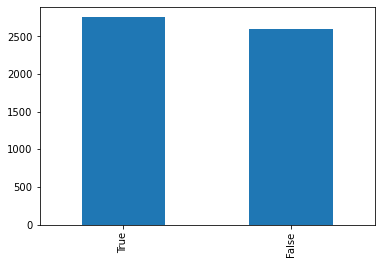

In [8]:
y_train.value_counts().plot.bar()

In [10]:
X_train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,5248.000000,5239.000000,5247.000000,5215.000000,5233.000000,5253.000000
mean,28.757241,225.140294,465.724033,175.651007,312.986050,289.920046
std,14.436131,669.961513,1670.162509,630.302286,1165.836151,1073.166045
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,48.000000,64.500000,23.000000,57.000000,44.000000
max,79.000000,14327.000000,27723.000000,23492.000000,22408.000000,20336.000000


<AxesSubplot:>

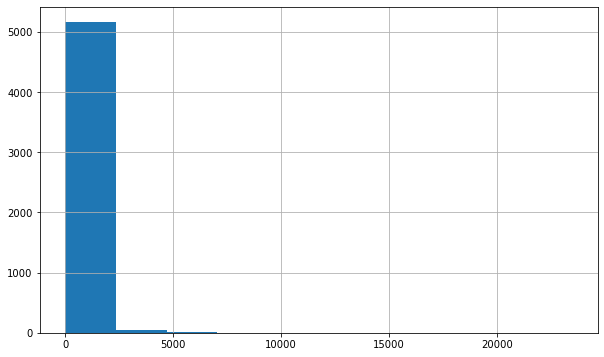

In [13]:
X_train['ShoppingMall'].hist(figsize=(10,6))

In [14]:
X_train.describe(include='object')

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
count,5354,5227,5223,5238,5223,5246,5230
unique,5354,3,2,4360,3,2,5225
top,3949_01,Earth,False,C/137/S,TRAPPIST-1e,False,Asch Stradick
freq,1,2836,3319,7,3637,5123,2


### EDA Notes:

- Both numerical and categorical columns (process differently)
- All features are missing values
- Target column is full and balanced
- Few of the object columns of thousands of unique values (not appropriate OHE)

### Data Preprocessing

- Numerical
    - Impute with median (skew in distributions)
    - StandardScale
- Categorical
    - Impute most_frequent
    - OHE

In [18]:
# List of numerical and categorical column names to process the data separately
num_cols = list(X_train.select_dtypes(include='number').columns)
cat_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

Instantiate SimpleImputer and StandardScaler to process numerical data

In [19]:
num_imputer = SimpleImputer(strategy='median')
num_scaler = StandardScaler()

In [20]:
X_train_pre = X_train.copy()

In [21]:
X_train_pre[num_cols]

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
2821,14.0,781.0,0.0,1.0,4.0,1.0
3875,36.0,386.0,0.0,756.0,6.0,0.0
807,32.0,0.0,1755.0,0.0,0.0,67.0
462,38.0,0.0,0.0,0.0,1018.0,0.0
879,21.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
3772,8.0,0.0,0.0,0.0,0.0,0.0
5191,22.0,0.0,0.0,1128.0,0.0,45.0
5226,28.0,0.0,0.0,0.0,0.0,0.0
5390,34.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# Fit num_imputer to training data
num_imputer.fit(X_train_pre[num_cols])

SimpleImputer(strategy='median')

In [23]:
X_train_pre[num_cols] = num_imputer.transform(X_train_pre[num_cols])

In [24]:
X_train_pre[num_cols].isna().sum()

Age             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64

In [26]:
# Fit scaler
num_scaler.fit(X_train_pre[num_cols])

StandardScaler()

In [27]:
# Scale numerical data
X_train_pre[num_cols] = num_scaler.transform(X_train_pre[num_cols])

In [41]:
X_train[num_cols]

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
2821,14.0,781.0,0.0,1.0,4.0,1.0
3875,36.0,386.0,0.0,756.0,6.0,0.0
807,32.0,0.0,1755.0,0.0,0.0,67.0
462,38.0,0.0,0.0,0.0,1018.0,0.0
879,21.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
3772,8.0,0.0,0.0,0.0,0.0,0.0
5191,22.0,0.0,0.0,1128.0,0.0,45.0
5226,28.0,0.0,0.0,0.0,0.0,0.0
5390,34.0,0.0,0.0,0.0,0.0,0.0


In [42]:
X_train['Age'].describe()

count    5248.000000
mean       28.757241
std        14.436131
min         0.000000
25%        19.000000
50%        27.000000
75%        38.000000
max        79.000000
Name: Age, dtype: float64

In [28]:
X_train_pre[num_cols]

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
2821,-1.030028,0.845099,-0.275861,-0.273179,-0.261755,-0.266495
3875,0.509160,0.249742,-0.275861,0.939411,-0.260021,-0.267435
807,0.229308,-0.332050,0.784872,-0.274786,-0.265223,-0.204443
462,0.649086,-0.332050,-0.275861,-0.274786,0.617373,-0.267435
879,-0.540287,-0.332050,-0.275861,-0.274786,-0.265223,-0.267435
...,...,...,...,...,...,...
3772,-1.449807,-0.332050,-0.275861,-0.274786,-0.265223,-0.267435
5191,-0.470324,-0.332050,-0.275861,1.536873,-0.265223,-0.225127
5226,-0.050545,-0.332050,-0.275861,-0.274786,-0.265223,-0.267435
5390,0.369234,-0.332050,-0.275861,-0.274786,-0.265223,-0.267435


In [29]:
logreg = LogisticRegression()

In [31]:
logreg.fit(X_train_pre[num_cols], y_train)

LogisticRegression()

In [32]:
logreg.score(X_train_pre[num_cols], y_train)

0.7807246918192006

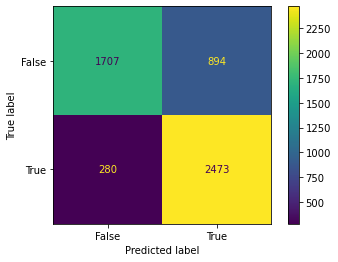

In [33]:
plot_confusion_matrix(logreg, X_train_pre[num_cols], y_train)

Prep test data for prediction

In [34]:
X_test_pre = X_test.copy()

In [35]:
X_test_pre[num_cols] = num_imputer.transform(X_test_pre[num_cols])

In [36]:
X_test_pre[num_cols] = num_scaler.transform(X_test_pre[num_cols])

In [38]:
X_test_pre[num_cols].isna().sum()

Age             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64

In [39]:
X_test_pre[num_cols].head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
5356,0.229308,-0.041154,-0.275861,1.517600,-0.265223,-0.267435
5491,-0.540287,0.599420,-0.255916,-0.273179,-0.263489,-0.267435
179,-0.120508,-0.332050,-0.275861,-0.274786,-0.265223,-0.267435
5472,2.678016,-0.332050,-0.275861,-0.274786,-0.265223,-0.267435
6578,1.488644,-0.332050,-0.275861,-0.274786,-0.265223,-0.267435


In [40]:
logreg.score(X_test_pre[num_cols], y_test)

0.7625093353248693

## Introducing ML Pipeline

Let's begin exploring pipelines and how we can implement them into our workflow. We'll start by reviewing the process we went through above and discuss how we should construct our pipeline architecture.

Two fundamental components:
- Transformer(s)
- Estimator(s)

![Pipeline Architecture Diagram](./Pipeline_Architecture.png)


The primary tool we will use is sklearn's [Pipeline object](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). 
Since the preprocessing steps differ for numerical and categorical data, we will also utilize sklearn's [ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) to specify the correct steps for different columns.

### Create and Explore a Pipeline

The first thing we should do is handle the preprocessing steps. Let's create a pipeline for preprocessing the categorical columns we didn't get to earlier.

In [44]:
# Create pipeline to preprocess categorical data
cat_transformer = Pipeline(steps = [
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False))
])

In [45]:
# Fit pipeline like any other transformer
cat_transformer.fit(X_train_pre[cat_cols])

Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                ('ohe', OneHotEncoder(sparse=False))])

In [48]:
X_train_pre[cat_cols]

,HomePlanet,CryoSleep,Destination,VIP
2821,Earth,False,TRAPPIST-1e,False
3875,Mars,False,TRAPPIST-1e,False
807,Earth,False,TRAPPIST-1e,False
462,Earth,False,TRAPPIST-1e,False
879,Mars,True,TRAPPIST-1e,False
...,...,...,...,...
3772,Mars,True,TRAPPIST-1e,False
5191,Mars,False,TRAPPIST-1e,False
5226,Earth,True,PSO J318.5-22,False
5390,Mars,True,TRAPPIST-1e,False


In [54]:
pd.DataFrame(cat_transformer.transform(X_train_pre[cat_cols]), 
                columns=cat_transformer.named_steps['ohe'].get_feature_names())

,x0_Earth,x0_Europa,x0_Mars,x1_False,x1_True,x2_55 Cancri e,x2_PSO J318.5-22,x2_TRAPPIST-1e,x3_False,x3_True
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
5349,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
5350,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
5351,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
5352,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


In [53]:
cat_transformer.named_steps['ohe'].get_feature_names()

array(['x0_Earth', 'x0_Europa', 'x0_Mars', 'x1_False', 'x1_True',
       'x2_55 Cancri e', 'x2_PSO J318.5-22', 'x2_TRAPPIST-1e', 'x3_False',
       'x3_True'], dtype=object)

In [56]:
set_config(display='text')
cat_transformer

Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                ('ohe', OneHotEncoder(sparse=False))])

### Complete Process

- Pipeline to process numerical columns
- ColumnTransformer
- Final pipeline

In [57]:
# Create pipeline to handle numerical features
num_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [58]:
num_transformer.fit(X_train[num_cols])

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

In [59]:
pd.DataFrame(num_transformer.transform(X_train[num_cols]), columns=num_cols)

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,-1.030028,0.845099,-0.275861,-0.273179,-0.261755,-0.266495
1,0.509160,0.249742,-0.275861,0.939411,-0.260021,-0.267435
2,0.229308,-0.332050,0.784872,-0.274786,-0.265223,-0.204443
3,0.649086,-0.332050,-0.275861,-0.274786,0.617373,-0.267435
4,-0.540287,-0.332050,-0.275861,-0.274786,-0.265223,-0.267435
...,...,...,...,...,...,...
5349,-1.449807,-0.332050,-0.275861,-0.274786,-0.265223,-0.267435
5350,-0.470324,-0.332050,-0.275861,1.536873,-0.265223,-0.225127
5351,-0.050545,-0.332050,-0.275861,-0.274786,-0.265223,-0.267435
5352,0.369234,-0.332050,-0.275861,-0.274786,-0.265223,-0.267435


In [60]:
preprocessor = ColumnTransformer(transformers = [
    ('num_transformer', num_transformer, num_cols),
    ('cat_transformer', cat_transformer, cat_cols)
], remainder='drop')

In [61]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num_transformer',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Age', 'RoomService', 'FoodCourt',
                                  'ShoppingMall', 'Spa', 'VRDeck']),
                                ('cat_transformer',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(sparse=False))]),
                                 ['HomePlanet', 'CryoSleep', 'Destination',
                                  'VIP'])])

In [62]:
set_config(display='diagram')
preprocessor

ColumnTransformer(transformers=[('num_transformer',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Age', 'RoomService', 'FoodCourt',
                                  'ShoppingMall', 'Spa', 'VRDeck']),
                                ('cat_transformer',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(sparse=False))]),
                                 ['HomePlanet', 'CryoSleep', 'Destination',
                                  'VIP'])])

In [64]:
pd.DataFrame(preprocessor.transform(X_train)).isna().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
dtype: int64

In [65]:
# Embed preprocessor and estimator in final pipeline
full_pipeline = Pipeline(steps = [
    ('preprocess', preprocessor),
    ('estimator', LogisticRegression())
])

In [66]:
full_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck']),
                                                 ('cat_transformer',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Destination', 'VIP'])])),
                ('estimator', LogisticRegression())])

In [67]:
train_preds = full_pipeline.predict(X_train)

In [68]:
accuracy_score(y_train, train_preds)

0.7908106088905491

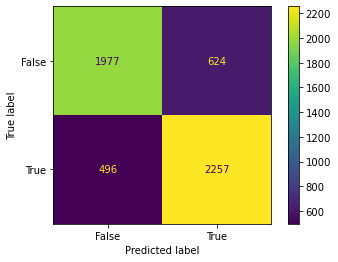

In [69]:
plot_confusion_matrix(full_pipeline, X_train, y_train)

In [70]:
test_preds = full_pipeline.predict(X_test)

In [71]:
accuracy_score(y_test, test_preds)

0.7976101568334578

In [72]:
cross_val_score(full_pipeline, X_train, y_train, cv=5)

array([0.80392157, 0.76937442, 0.79365079, 0.79831933, 0.78317757])

The pipeline is visualized above in a text format. You can display pipeline in a more interactive format using [set_config](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_pipeline_display.html#sphx-glr-auto-examples-miscellaneous-plot-pipeline-display-py)

### Iterate

Having the steps predefined and modularized makes it easy to experiment and fine-tune each part of the process!

In [73]:
rfc_pipe = Pipeline(steps = [
    ('preprocess', preprocessor),
    ('rfc', RandomForestClassifier())
])

In [74]:
rfc_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck']),
                                                 ('cat_transformer',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Destination', 'VIP'])])),
                ('rfc', RandomForestClassifier())])

In [76]:
rfc_pipe.score(X_train, y_train)

0.9288382517743743

In [77]:
rfc_pipe.score(X_test, y_test)

0.7923823749066468

In [82]:
set_config(display='text')
rfc_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck']),
                                                 ('cat_transformer',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
   

## Grid Search

Using pipelines is almost exactly the same, we will just need to make a few adjustments to the parameter dictionary.

In [95]:
param_grid = {
    'rfc__max_depth': [2, 8, 12, 20],
    'rfc__min_samples_split': [2, 6]
}

In [96]:
gs = GridSearchCV(rfc_pipe, param_grid, cv=5)

In [97]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num_transformer',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'RoomService',
                                                                          'FoodCourt',
                                                                          'ShoppingMall',
                                                   

In [102]:
gs.best_estimator_.named_steps['rfc']

RandomForestClassifier(max_depth=8, min_samples_split=6)

In [103]:
gs.best_estimator_.score(X_train, y_train)

0.8289129622711991

In [104]:
gs.best_estimator_.score(X_test, y_test)

0.7998506348020911